# SOFC + SOEC Model

This notebook contains a solid oxide fuel cell (SOFC) coupled with a solid oxide electrolysis cell (SOEC) system. Both components can be run at partial load, between 200 - 680 MW for the SOFC and between 1 - 5 kg/s hydrogen production for the SOEC. The systems are coupled physically and electrically. The SOFC anode exhaust can be supplied to make steam for the SOEC or to power a bottoming steam cycle. Electricity from the SOFC is used to power the SOEC and balance of plant. If there is excess it can be supplied to the grid. The SOFC is modeled with surrogate equations generated from the SOFC example flowsheet. The surrogates contain one input, the SOFC direct current power. The surrogates are used to calculate the SOFC anode exhaust flowrate, temperature, and composition, the SOFC balance of plant load, and natural gas use.

## Module Imports

In [1]:
import os
import numpy as np
import pandas as pd
import pytest
from IPython.core.display import SVG

import pyomo.environ as pyo
from pyomo.environ import units as pyunits
from pyomo.util.infeasible import log_infeasible_constraints

import idaes
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util as iutil

from sofc_with_soec import (
    get_model,
    initialize,
    add_tags,
    write_pfd,
    make_stream_table
)
from sofc_soec_costing import (
    get_capital_cost,
    get_fixed_costs,
    get_variable_costs
)
import logging
logging.getLogger('pyomo.repn.plugins.nl_writer').setLevel(logging.ERROR)

## Make Output Directories

This notebook can produce a large number of output files.  To make it easier to manage, some subdirectories are used to organize output.  This ensures that the directories exist.

In [2]:
# Make a directory if it doesn't exist
def make_directory(path):
    if not os.path.exists(path):
        os.mkdir(path)
    
make_directory("data")
make_directory("data_pfds")
make_directory("data_tabulated")

## Global Solver Settings

Use the IDAES configuration system for solver settings. These will apply to all Ipopt instances created, including the ones created in initialization methods.

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.linear_solver = "ma57"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt.options.ma57_pivtol = 1e-5
idaes.cfg.ipopt.options.ma57_pivtolmax = 0.1
idaes.cfg.ipopt.options.bound_push = 1e-20
solver = pyo.SolverFactory("ipopt")

## Create the SOFC + SOEC model

Create the SOFC + SOEC model and initialize it or read the saved initialization if available.

In [4]:
def get_base_sofc_soec_model(solve=True):
    m = get_model()
    save_name = "sofc_soec_init.json.gz"
    if os.path.exists(save_name):
        iutil.from_json(m, fname=save_name, wts=iutil.StoreSpec(suffix=False))
        print("Loading initialized model from json")
    else:
        initialize(m)
        iutil.to_json(m, fname=save_name)
    
    if solve:
        res = solver.solve(m, tee=True)

    return m

## Design Optimization

In [5]:
def add_optimization_constraints(m):
    # make sure the delta T on the hydrogen side is 40K or less (it is
    # squared so one constraint covers both positive and negative delta T)
    @m.fs.Constraint(m.fs.time)
    def delta_T_h_constraint(b, t):
        return (
            m.fs.feed_heater.control_volume.properties_out[t].temperature -
            m.fs.feed_recycle_split.mixed_state[t].temperature
        )**2/100 <= 16

    # make sure the delta T on the oxygen side is 40K or less
    @m.fs.Constraint(m.fs.time)
    def delta_T_o_constraint(b, t):
        return (
            m.fs.soec_module.oxygen_inlet.temperature[t] -
            m.fs.soec_module.oxygen_outlet.temperature[t]
        )**2/100 <= 16

    # make sure the oxygen inlet and hydrogen outlet are 40K or less apart
    @m.fs.Constraint(m.fs.time)
    def delta_T_1_constraint(b, t):
        return (
            m.fs.soec_module.oxygen_inlet.temperature[t] -
            m.fs.feed_recycle_split.mixed_state[t].temperature
        )**2/100 <= 16

    # make sure the hydrogen inlet and oxygen outlet are 40K or less apart
    @m.fs.Constraint(m.fs.time)
    def delta_T_2_constraint(b, t):
        return (
            m.fs.feed_heater.control_volume.properties_out[t].temperature -
            m.fs.soec_module.oxygen_outlet.temperature[t]
        )**2/100 <= 16

    @m.fs.Constraint(m.fs.time)
    def average_current_density_constraint(b, t):
        return m.fs.soec_module.solid_oxide_cell.average_current_density[0]/1000 >= -8

    @m.fs.Constraint(m.fs.time)
    def positive_steam_cycle(b, t):
        return m.fs.steam_cycle_heat_duty[t] >= 0

In [6]:
m = get_base_sofc_soec_model()

# add costs
get_capital_cost(m)
get_fixed_costs(m)
get_variable_costs(m)

# set up design optimization problem
m.fs.obj = pyo.Objective(
    expr=(
        m.fs.costing.annualized_tasc +
        m.fs.costing.total_fixed_OM_cost +
        m.fs.costing.total_variable_OM_cost[0] +
        (-m.fs.net_power[0]/1000 * 60 / 1e6 * 24 * 365)
    )
)

# add design and operating constraints
add_optimization_constraints(m)

m.fs.soec_module.oxygen_outlet.temperature[0].setub(1030)
m.fs.soec_module.fuel_outlet.temperature[0].setub(1030)
m.fs.soec_module.oxygen_outlet.mole_frac_comp[0, "O2"].setub(0.35)
m.fs.soec_single_pass_water_conversion.setub(0.90)
m.fs.feed_recycle_split.mixed_state[0].mole_frac_comp["H2O"].setlb(0.20)
m.fs.h2_condenser.control_volume.properties_in[0].temperature.setlb(350)
m.fs.fg_flash.control_volume.properties_in[0].temperature.setlb(350)

# unfix decision vars
decision_vars = []

def make_decision_var(v, lb, ub):
    v.unfix()
    v.setlb(lb)
    v.setub(ub)
    decision_vars.append(v)

make_decision_var(m.fs.feed_recycle_split.split_fraction[0, "out"], 0.25, 0.95)
make_decision_var(m.fs.sweep_compressor.inlet.flow_mol[0], 100, 8000)
make_decision_var(m.fs.soec_module.potential_cell[0], 1.26, 1.38) # already free
m.fs.soec_single_pass_water_conversion.unfix()
make_decision_var(m.fs.feed_heater.control_volume.properties_out[0].temperature, 900, 1020)
make_decision_var(m.fs.soec_module.number_cells, 1e6, 2e6)
make_decision_var(m.fs.sweep_hx.area, 100, 10000)
make_decision_var(m.fs.sweep_heater.area, 100, 10000)  # already free
m.fs.sweep_heater.tube_outlet.temperature.unfix()
make_decision_var(m.fs.boiler.area, 100, 10000)  # already free
m.fs.oxycombustor.heat_duty.unfix()
make_decision_var(m.fs.feed_hx.area, 100, 10000)  # already free
m.fs.feed_hx.shell_outlet.temperature.unfix()
make_decision_var(m.fs.oxycombustor_mix.gas_inlet.flow_mol[0], 0, 50000)

save_name = "sofc_soec_design_opt.json.gz"
if os.path.exists(save_name):
    iutil.from_json(m, fname=save_name, wts=iutil.StoreSpec(suffix=False))
    print("Loading optimized design from json")
else:
    res = solver.solve(m, tee=True)
    iutil.to_json(m, fname=save_name)

Loading initialized model from json
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
max_iter=200
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
bound_push=1e-20
option_file_name=/var/folders/xf/4r1nvwm50_d1069gf048n6p80000gn/T/tmp4mpum2m9_ipopt.opt

Using option file "/var/folders/xf/4r1nvwm50_d1069gf048n6p80000gn/T/tmp4mpum2m9_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was comp

## Show PFDs with design optimization results
This displays PFDs in the notebook, and saves them to files.

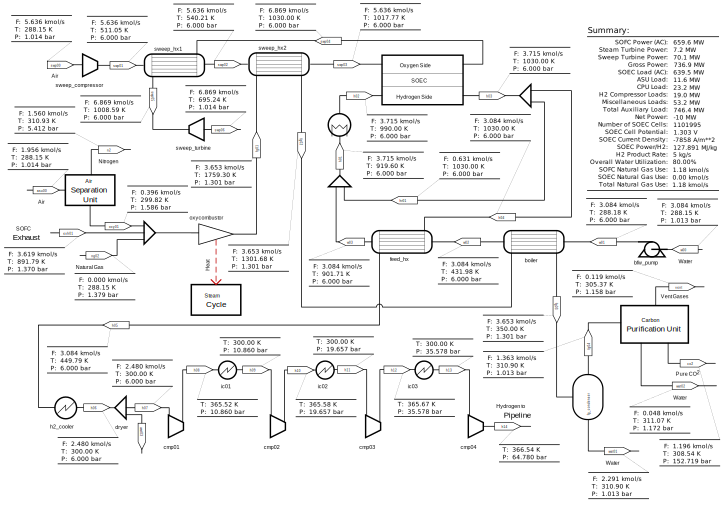

In [7]:
display(SVG(write_pfd(m)))
write_pfd(m, fname="data_pfds/sofc_soec_results.svg")

In [8]:
# assert that flowsheet values have not changed from prior runs
assert m.fs.feed_recycle_split.split_fraction[0, 'out'].value == pytest.approx(0.8302, rel=0.01)
assert m.fs.sweep_compressor.inlet.flow_mol[0].value == pytest.approx(5635.58, rel=0.01)
assert m.fs.soec_module.potential_cell[0].value == pytest.approx(1.3026, rel=0.01)
assert m.fs.feed_heater.control_volume.properties_out[0].temperature.value == pytest.approx(990.00, rel=0.01)
assert m.fs.soec_module.number_cells.value == pytest.approx(1101995, rel=0.01)
assert m.fs.sweep_hx.area.value == pytest.approx(100.00, rel=0.01)
assert m.fs.sweep_heater.area.value == pytest.approx(1137.15, rel=0.01)
assert m.fs.boiler.area.value == pytest.approx(4865.23, rel=0.01)
assert m.fs.feed_hx.area.value == pytest.approx(9999.99, rel=0.01)

print("------------------------------------------")
print("Decision Variable Results")
print("------------------------------------------")
print(f"Feed recycle = {m.fs.feed_recycle_split.split_fraction[0, 'out'].value}")
print(f"Sweep flowrate = {m.fs.sweep_compressor.inlet.flow_mol[0].value} mol/s")
print(f"SOEC potential = {m.fs.soec_module.potential_cell[0].value} V")
print(f"Feed trim heater temperature = {m.fs.feed_heater.control_volume.properties_out[0].temperature.value} K")
print(f"Number of cells = {m.fs.soec_module.number_cells.value}")
print(f"Sweep hx 1 area = {m.fs.sweep_hx.area.value} ft^2")
print(f"Sweep hx 2 area = {m.fs.sweep_heater.area.value} ft^2")
print(f"Boiler area = {m.fs.boiler.area.value} ft^2")
print(f"Feed hx area = {m.fs.feed_hx.area.value} ft^2")
print(f"Natural gas flowrate = {m.fs.oxycombustor_mix.gas_inlet.flow_mol[0].value} mol/s")

print("\n")
print("------------------------------------------")
print("Capital Costs")
print("------------------------------------------")
print(f"SOFC modules = MM${m.fs.sofc_modules.costing.total_plant_cost.value}")
print(f"SOFC balance of plant = MM${m.fs.sofc_bop.costing.total_plant_cost.value}")
print(f"SOEC modules = MM${m.fs.soec_module.costing.total_plant_cost.value}")
print(f"SOEC balance of plant = MM${pyo.value(m.fs.costing.soec_bop_cost)}")
print(f"Hydrogen Compressor = MM${m.fs.cmp01.costing.total_plant_cost.value}")
print(f"Oxycombustor = MM${m.fs.oxycombustor.costing.total_plant_cost.value}")
print(f"Air separation unit = MM${m.fs.asu_split.costing.total_plant_cost.value}")
print(f"Carbon purification unit = MM${m.fs.cpu_cost.costing.total_plant_cost.value}")
print(f"Feedwater and misc. BOP systems = MM${pyo.value(m.fs.costing.feedwater_bop_cost)}")
print(f"HRSG, ductwork, and stack = MM${pyo.value(m.fs.costing.hrsg_ductwork_and_stack_cost)}")
print(f"Steam turbine generator = MM${pyo.value(m.fs.costing.steam_turbine_cost)}")
print(f"Cooling water system = MM${pyo.value(m.fs.costing.cooling_water_system_cost)}")
print(f"Electric equipment = MM${pyo.value(m.fs.costing.accessory_electric_plant_cost)}")
print(f"Instrumentation and control = MM${pyo.value(m.fs.costing.instrumentation_and_control_cost)}")
print(f"Improvements to site = MM${pyo.value(m.fs.costing.improvements_to_site_cost)}")
print(f"Buildings and structures = MM${pyo.value(m.fs.costing.buildings_and_structures_cost)}")
print("\n")
print(f"Total Plant Cost = MM${m.fs.costing.total_TPC.value}")
print(f"Total Overnight Cost = MM${m.fs.costing.total_overnight_cost.value}")
print(f"Total As Spent Cost = MM${m.fs.costing.total_as_spent_cost.value}")
print(f"Annualized TASC = MM${m.fs.costing.annualized_tasc.value}/year")

print("\n")
print("------------------------------------------")
print("Fixed and Variable O&M Costs")
print("------------------------------------------")
print(f"Annual operating labor = MM${m.fs.costing.annual_operating_labor_cost.value}/year")
print(f"Maintenance labor = MM${m.fs.costing.maintenance_labor_cost.value}/year")
print(f"Admin & support labor = MM${m.fs.costing.admin_and_support_labor_cost.value}/year")
print(f"Property taxes & insurance = MM${m.fs.costing.property_taxes_and_insurance.value}/year")
print(f"Maintenance material cost = MM${m.fs.costing.maintenance_material_cost.value}/year")
print(f"SOFC replacement cost = MM${m.fs.costing.sofc_replacement_cost.value}/year")
print(f"SOFC replacement cost = MM${m.fs.costing.soec_replacement_cost.value}/year")
print(f"Total Fixed O&M Cost = MM${m.fs.costing.total_fixed_OM_cost.value}/year")
print(f"Total Variable O&M Cost = MM${m.fs.costing.total_variable_OM_cost[0].value}/year")

------------------------------------------
Decision Variable Results
------------------------------------------
Feed recycle = 0.8302182349390057
Sweep flowrate = 5635.584047695349 mol/s
SOEC potential = 1.3026545751526968 V
Feed trim heater temperature = 990.0000112464168 K
Number of cells = 1101995.0230871127
Sweep hx 1 area = 100.00003477701021 ft^2
Sweep hx 2 area = 1137.1569684437054 ft^2
Boiler area = 4865.233245889823 ft^2
Feed hx area = 9999.999486214741 ft^2
Natural gas flowrate = 1.1972315969081855e-06 mol/s


------------------------------------------
Capital Costs
------------------------------------------
SOFC modules = MM$233.582
SOFC balance of plant = MM$31.5456
SOEC modules = MM$73.78628076084381
SOEC balance of plant = MM$34.518357565799654
Hydrogen Compressor = MM$21.1012651621793
Oxycombustor = MM$18.354599318124862
Air separation unit = MM$79.22249574756023
Carbon purification unit = MM$84.15785143974655
Feedwater and misc. BOP systems = MM$66.94536284726492
HRSG, 

## Run Partial Load

This runs the SOFC at partial load from 680 MW to 200 MW at 20 MW intervals and the SOEC from 5 kg/s to 1 kg/s at 0.5 kg/s intervals. Results are tabulated for tags in the tags_output tag group in a Pandas data frame.

To run the series, change run_series to True. Running the turndown series takes ~2 hours, unless previous saved results are available.

In [9]:
run_series = False
if run_series:
    idaes.cfg.ipopt.options.tol = 1e-6
    idaes.cfg.ipopt.options.mu_init = 1e-3
    solver = pyo.SolverFactory("ipopt")

    # rebuild the model since capital costs are already fixed
    m = get_base_sofc_soec_model(solve=False)
    get_variable_costs(m)
    add_optimization_constraints(m)
    
    # load in optimized design
    save_name = "sofc_soec_design_opt.json.gz"
    iutil.from_json(m, fname=save_name, wts=iutil.StoreSpec(suffix=False))

    # fix the design vars
    m.fs.soec_module.number_cells.fix()
    m.fs.sweep_hx.area.fix()
    m.fs.sweep_heater.area.fix()
    m.fs.boiler.area.fix()
    m.fs.feed_hx.area.fix()
    m.fs.costing.other_variable_costs.fix(0)

    m.fs.obj = pyo.Objective(
        expr=(
            m.fs.costing.total_variable_OM_cost[0] +
            (-m.fs.net_power[0]/1000 * 60 / 1e6 * 24 * 365)
        )
    )

    add_tags(m)
    df = pd.DataFrame(columns=m._tags_output.table_heading())

    for p in range(680, 199, -20):
        for h in [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1]:
            print(f"power: {int(p)}, hydrogen: {float(h)}")

            m.fs.sofc_power.fix(p)
            m.fs.hydrogen_product_rate.fix(h)

            fname = f"data/sofc+soec_{int(p)}_{h}.json.gz"
            if os.path.exists(fname):
                iutil.from_json(m, fname=fname, wts=iutil.StoreSpec(suffix=False))
            else:
                res = solver.solve(m, tee=True, symbolic_solver_labels=True)
                if not pyo.check_optimal_termination(res):
                    break
                iutil.to_json(m, fname=fname)

            df.loc[m._tags_output["net_power"].value] = m._tags_output.table_row(numeric=True)
    df.to_csv("data_tabulated/sofc+soec.csv")